### Configuration and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import scipy.ndimage

from neural_final_proj.core_models import CustomCNN, ResNetSmall 
from neural_final_proj.basic_utils import prepare_data_loaders
from neural_final_proj.interpretability import GradCAM, visualize_saliency_map
from neural_final_proj.adversarial_utils import (
    train_robust_model,
    load_models_for_attack, 
    generate_adversarial_set, 
    transferability_test,
    plot_all_adversarial_samples_to_dir
)

In [ ]:
class ConfigB:
    data_root = "data/Sports" 
    image_size = 64
    batch_size = 64
    num_classes = 10 
    device = torch.device("cpu") 
    
    # Model checkpoint paths
    ckpt_dir = "problem_A_outputs" 
    model_a_ckpt = "CustomCNN-original.pt"
    model_b_ckpt = "ResNetSmall-original.pt" # Assuming your ResNet was named ResNetSmall
    out_dir = "problem_B_outputs"

    # Attack settings
    eps = 32 / 255.0
    pgd_alpha = 2 / 255.0
    pgd_steps = 20

    target_class_name = "basketball" 

cfg = ConfigB()

In [3]:
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir('..')
current_folder_name = os.path.basename(os.getcwd())
os.makedirs(cfg.out_dir, exist_ok=True)

WIDTH = 19
print(f"{'Current directory':<{WIDTH}}: {current_folder_name}")
print(f"{'Device':<{WIDTH}}: {cfg.device}")
print(f"{'Using target class':<{WIDTH}}: {cfg.target_class_name}")
print(f"{'Output Location':<{WIDTH}}: {cfg.out_dir}\n")

val_loader, _, class_names, _ = prepare_data_loaders(
    cfg.data_root, cfg.image_size, cfg.batch_size
)

# Load trained models from Part A
model_a, model_b, basketball_idx = load_models_for_attack(
    cfg, CustomCNN, ResNetSmall, class_names, cfg.ckpt_dir, cfg.model_a_ckpt, cfg.model_b_ckpt
)

print(f"\nBasketball index (Target Index) : {basketball_idx}")

Current directory  : EE4745_Final_Proj
Device             : cpu
Using target class : basketball
Output Location    : problem_B_outputs

Loading Model A from problem_A_outputs\CustomCNN-original.pt
Loading Model B from problem_A_outputs\ResNetSmall-original.pt

Basketball index (Target Index) : 1


### Main Experiment Runner and Collection

In [4]:
all_results = {}
attacks_to_run = [
    ("fgsm", False, "Untargeted"),
    ("fgsm", True, "Targeted"),
    ("pgd", False, "Untargeted"),
    ("pgd", True, "Targeted"),
]
NUM_SAMPLES = 10 # Required number of examples per attack type

for attack_name, targeted, atype in attacks_to_run:
    key = f"{attack_name}_{atype}"
    print(f"\n--- Running {key} Attack ---")
    
    
    # --- Generate on Model A (Source) ---
    adv_a = generate_adversarial_set(
        model_a, val_loader, attack_name, cfg.eps, targeted, basketball_idx, num_samples=NUM_SAMPLES, 
        alpha=cfg.pgd_alpha, steps=cfg.pgd_steps
    )
    
    # Test Transfer A -> B
    transfer_a_to_b = transferability_test(adv_a, model_b, targeted, basketball_idx)


    # --- Generate on Model B (Source) ---
    adv_b = generate_adversarial_set(
        model_b, val_loader, attack_name, cfg.eps, targeted, basketball_idx, num_samples=NUM_SAMPLES, 
        alpha=cfg.pgd_alpha, steps=cfg.pgd_steps
    )
    
    # Test Transfer B -> A
    transfer_b_to_a = transferability_test(adv_b, model_a, targeted, basketball_idx)
    
    success_a = sum(int(e["success"]) for e in adv_a) / max(len(adv_a), 1)
    success_b = sum(int(e["success"]) for e in adv_b) / max(len(adv_b), 1)

    all_results[key] = {
        "Model A Success Rate": success_a,
        "Model B Success Rate": success_b,
        "Transfer A->B Rate": transfer_a_to_b,
        "Transfer B->A Rate": transfer_b_to_a,
        "Avg Linf Norm (A)": np.mean([e['linf'] for e in adv_a]),
        "Avg L2 Norm (A)": np.mean([e['l2'] for e in adv_a]),
        "Adv_A Examples": adv_a, # Keep examples for final report details
        "Adv_B Examples": adv_b,
    }

    print(f"Model A Success: {success_a:.3f} | Transfer A->B: {transfer_a_to_b:.3f}")
    print(f"Model B Success: {success_b:.3f} | Transfer B->A: {transfer_b_to_a:.3f}")


--- Running fgsm_Untargeted Attack ---
Model A Success: 0.800 | Transfer A->B: 0.500
Model B Success: 0.900 | Transfer B->A: 0.000

--- Running fgsm_Targeted Attack ---
Model A Success: 0.300 | Transfer A->B: 0.000
Model B Success: 0.000 | Transfer B->A: 0.000

--- Running pgd_Untargeted Attack ---
Model A Success: 0.900 | Transfer A->B: 0.500
Model B Success: 1.000 | Transfer B->A: 0.200

--- Running pgd_Targeted Attack ---
Model A Success: 0.500 | Transfer A->B: 0.000
Model B Success: 0.500 | Transfer B->A: 0.100


### Final Reporting Table

In [5]:
data_for_df = []
for key, res in all_results.items():
    attack_name, targeted = key.split('_')
    
    data_for_df.append({
        'Attack': attack_name.upper(),
        'Targeted': targeted.capitalize(),
        'Source Success (A)': f"{res['Model A Success Rate']:.3f}",
        'Source Success (B)': f"{res['Model B Success Rate']:.3f}",
        'Transfer A->B': f"{res['Transfer A->B Rate']:.3f}",
        'Transfer B->A': f"{res['Transfer B->A Rate']:.3f}",
        'Avg Linf Norm': f"{res['Avg Linf Norm (A)']:.5f}",
        'Avg L2 Norm': f"{res['Avg L2 Norm (A)']:.5f}",
    })

df = pd.DataFrame(data_for_df)

print(f"Experiment Settings: L_inf Epsilon = {cfg.eps:.4f}, PGD Steps = {cfg.pgd_steps}")
print(df.to_markdown(index=False))

Experiment Settings: L_inf Epsilon = 0.1255, PGD Steps = 20
| Attack   | Targeted   |   Source Success (A) |   Source Success (B) |   Transfer A->B |   Transfer B->A |   Avg Linf Norm |   Avg L2 Norm |
|:---------|:-----------|---------------------:|---------------------:|----------------:|----------------:|----------------:|--------------:|
| FGSM     | Untargeted |                  0.8 |                  0.9 |             0.5 |             0   |         0.12549 |       13.6158 |
| FGSM     | Targeted   |                  0.3 |                  0   |             0   |             0   |         0.12549 |       13.6507 |
| PGD      | Untargeted |                  0.9 |                  1   |             0.5 |             0.2 |         0.12549 |       10.9466 |
| PGD      | Targeted   |                  0.5 |                  0.5 |             0   |             0.1 |         0.12549 |       11.0652 |


### Quick Inspection: Display a Single Successful Adversarial Example

Displaying quick visualization for: fgsm_Untargeted on Model A.


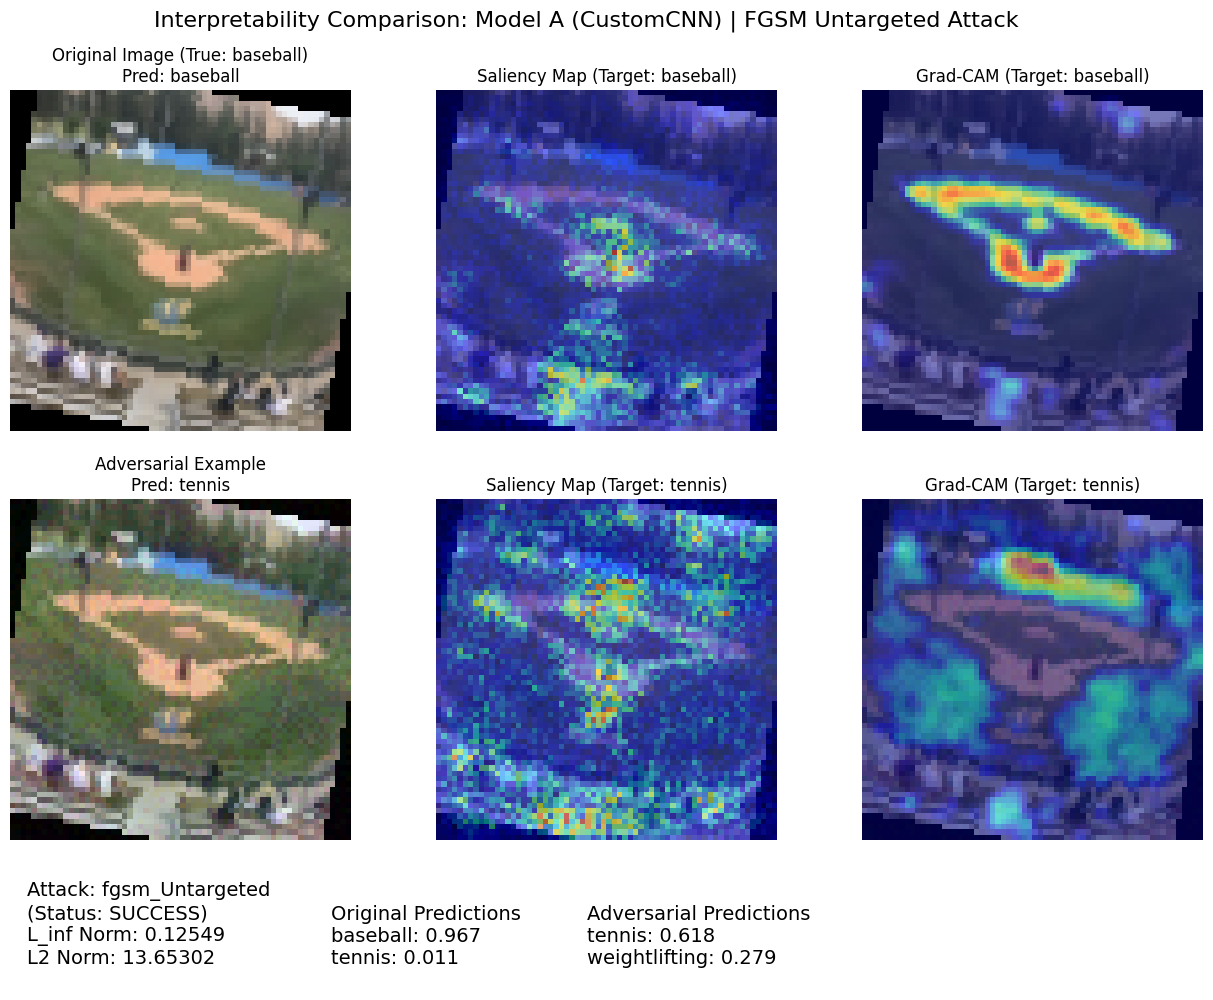

In [6]:
from neural_final_proj.adversarial_utils import plot_single_adversarial_sample

attack_key = 'fgsm_Untargeted'
adv_examples = all_results.get(attack_key, {}).get('Adv_A Examples', [])

single_sample = next((e for e in adv_examples if e.get('success', False)), adv_examples[0] if adv_examples else None)

if single_sample is not None:
    print(f"Displaying quick visualization for: {attack_key} on Model A.")
    plot_single_adversarial_sample(
        sample=single_sample,
        model=model_a,
        model_name='Model A (CustomCNN)',
        cfg=cfg,
        class_names=class_names,
        output_filepath=None 
    )
else:
    print(f"Could not find any successful samples in {attack_key} to display.")

### Save All Adversarial Comparison Plots

In [ ]:
print(f"Starting batch generation of all successful plots. Saving to {cfg.out_dir}...")

plot_all_adversarial_samples_to_dir(
    all_results=all_results,
    model_a=model_a,
    model_b=model_b,
    cfg=cfg,
    class_names=class_names
    sub_dir_name = "adversarial_plots"
)

Starting batch generation of all successful plots. Saving to problem_B_outputs...
ATTEMPT 1 (ModelA / fgsm_UT) | True Class: baseball | Status: SUCCESS
ATTEMPT 2 (ModelA / fgsm_UT) | True Class: volleyball | Status: SUCCESS
ATTEMPT 3 (ModelA / fgsm_UT) | True Class: basketball | Status: SUCCESS
ATTEMPT 4 (ModelA / fgsm_UT) | True Class: hockey | Status: FAILURE
ATTEMPT 5 (ModelA / fgsm_UT) | True Class: volleyball | Status: FAILURE
ATTEMPT 6 (ModelA / fgsm_UT) | True Class: baseball | Status: SUCCESS
ATTEMPT 7 (ModelA / fgsm_UT) | True Class: basketball | Status: SUCCESS
ATTEMPT 8 (ModelA / fgsm_UT) | True Class: hockey | Status: SUCCESS
ATTEMPT 9 (ModelA / fgsm_UT) | True Class: football | Status: SUCCESS
ATTEMPT 10 (ModelA / fgsm_UT) | True Class: tennis | Status: SUCCESS
ATTEMPT 1 (ModelB / fgsm_UT) | True Class: football | Status: SUCCESS
ATTEMPT 2 (ModelB / fgsm_UT) | True Class: volleyball | Status: SUCCESS
ATTEMPT 3 (ModelB / fgsm_UT) | True Class: rugby | Status: SUCCESS
ATTEMP

### Defense Configuration

In [9]:
class ConfigB_Extra(ConfigB):
    NUM_ROBUST_EPOCHS = 10 
    
    # Adversarial Training parameters (PGD-AT)
    PGD_EPS = ConfigB.eps
    PGD_ALPHA = ConfigB.pgd_alpha
    PGD_STEPS = ConfigB.pgd_steps
    
    ROBUST_OUT_DIR = "problem_B_outputs/robust_checkpoints"

cfg_defense = ConfigB_Extra()

os.makedirs(cfg_defense.ROBUST_OUT_DIR, exist_ok=True)

print(f"Robust Model Output Dir: {cfg_defense.ROBUST_OUT_DIR}")

Robust Model Output Dir: problem_B_outputs/robust_checkpoints


### Train Robust Model (PGD Adversarial Training)

In [10]:
train_loader, val_loader, class_names, _ = prepare_data_loaders(
    cfg_defense.data_root, cfg_defense.image_size, cfg_defense.batch_size
)

model_a_robust = CustomCNN(num_classes=cfg_defense.num_classes).to(cfg_defense.device)

cfg_defense.num_epochs = cfg_defense.NUM_ROBUST_EPOCHS

robust_results = train_robust_model(
    model=model_a_robust, 
    model_name="CustomCNN", 
    train_loader=train_loader, 
    val_loader=val_loader, 
    cfg=cfg_defense
)

print("\n--- Robust Training Complete ---")
print(f"Final Validation Accuracy: {robust_results['final_val_accuracy']:.2f}%")


--- Starting ADVERSARIAL TRAINING for CustomCNN ---
Epoch 1/10 | Train Acc: 19.08% | Val Acc: 30.00% | Time: 25.95s
Epoch 2/10 | Train Acc: 27.62% | Val Acc: 34.00% | Time: 24.89s
Epoch 3/10 | Train Acc: 29.76% | Val Acc: 40.00% | Time: 24.16s
Epoch 4/10 | Train Acc: 33.77% | Val Acc: 44.00% | Time: 24.02s
Epoch 5/10 | Train Acc: 34.53% | Val Acc: 52.00% | Time: 24.24s
Epoch 6/10 | Train Acc: 36.22% | Val Acc: 58.00% | Time: 24.16s
Epoch 7/10 | Train Acc: 39.86% | Val Acc: 52.00% | Time: 25.36s
Epoch 8/10 | Train Acc: 41.12% | Val Acc: 46.00% | Time: 26.46s
Epoch 9/10 | Train Acc: 40.43% | Val Acc: 48.00% | Time: 24.39s
Epoch 10/10 | Train Acc: 41.87% | Val Acc: 48.00% | Time: 24.42s

--- Robust Training Complete ---
Final Validation Accuracy: 58.00%


### Evaluate Attack Success Rate Against Robust Model

In [11]:
attack_name = "fgsm"
targeted = False

print(f"\n--- Attacking Robust Model A ({attack_name.upper()}) ---")

adv_a_robust = generate_adversarial_set(
    model_a_robust, val_loader, attack_name, cfg.eps, targeted, basketball_idx, num_samples=10, 
    alpha=cfg.pgd_alpha, steps=cfg.pgd_steps
)

transfer_robust_a_to_original_a = transferability_test(adv_a_robust, model_a, targeted, basketball_idx)

success_a_robust = sum(int(e["success"]) for e in adv_a_robust) / max(len(adv_a_robust), 1)

print(f"Original Model A Success Rate (from all_results): {all_results['fgsm_Untargeted']['Model A Success Rate']:.3f}")
print(f"Robust Model A Success Rate (new): {success_a_robust:.3f}")
print(f"Transfer Robust A -> Original A: {transfer_robust_a_to_original_a:.3f}")


--- Attacking Robust Model A (FGSM) ---
Original Model A Success Rate (from all_results): 0.800
Robust Model A Success Rate (new): 0.300
Transfer Robust A -> Original A: 0.300


### Re-Evaluate Attack Success Rate Against Robust Model

In [12]:
attack_name = "fgsm"
targeted = False

print(f"\n--- Attacking Robust Model A ({attack_name.upper()}) ---")

adv_a_robust = generate_adversarial_set(
    model_a_robust, val_loader, attack_name, cfg_defense.PGD_EPS, targeted, basketball_idx, num_samples=10, 
    alpha=cfg_defense.PGD_ALPHA, steps=cfg_defense.PGD_STEPS
)

transfer_robust_a_to_original_a = transferability_test(adv_a_robust, model_a, targeted, basketball_idx)

success_a_robust = sum(int(e["success"]) for e in adv_a_robust) / max(len(adv_a_robust), 1)

print(f"Original Model A Success Rate (FGSM Untargeted): {all_results['fgsm_Untargeted']['Model A Success Rate']:.3f}")
print(f"Robust Model A Success Rate (new): {success_a_robust:.3f}")
print(f"Transfer Robust A -> Original A: {transfer_robust_a_to_original_a:.3f}")


--- Attacking Robust Model A (FGSM) ---
Original Model A Success Rate (FGSM Untargeted): 0.800
Robust Model A Success Rate (new): 0.300
Transfer Robust A -> Original A: 0.300


### Visualization of Robust Model Interpretability


--- Displaying Robust Model Interpretation on its OWN Adversarial Example ---


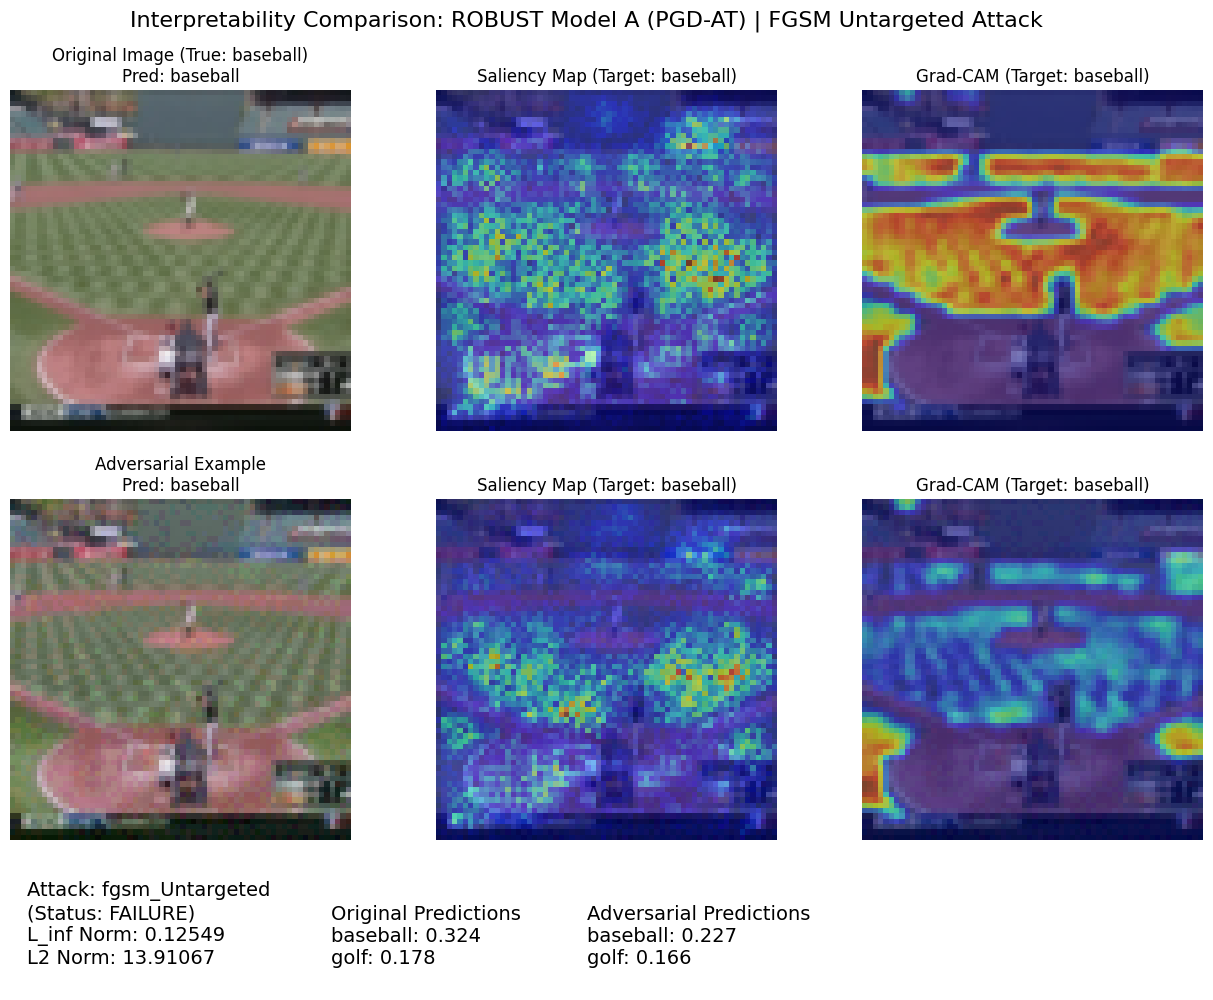

In [14]:
single_sample_robust = next((e for e in adv_a_robust if e.get('failure', False)), adv_a_robust[0] if adv_a_robust else None)

if single_sample_robust is not None:
    print("\n--- Displaying Robust Model Interpretation on its OWN Adversarial Example ---")

    plot_single_adversarial_sample(
        sample=single_sample_robust,
        model=model_a_robust,
        model_name='ROBUST Model A (PGD-AT)',
        cfg=cfg_defense,
        class_names=class_names,
        output_filepath=None
    )
else:
    print("Could not find any successful adversarial samples generated against the Robust Model to display.")